# Lab 6

For the LHC data, we are going to have to fake a background. Make a Poisson background with mean 100.

In [1]:
# imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import poisson

In [2]:
events = np.arange(0, 200)
mean = 100

distribution = poisson.pmf(events, mean)

## Problem 1

The first problem is to look at your background distribution and determine where the 5σ sensitivity threshold is. [Hint, you've done this several times now, look back at the first few labs.]

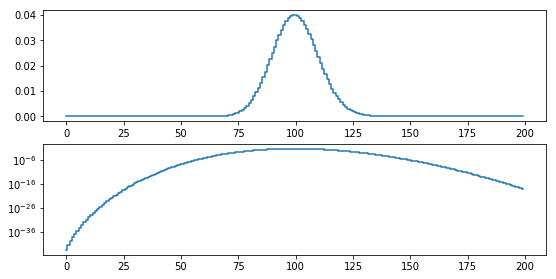

In [3]:
figure = plt.figure(figsize=(9, 4.5))
axes = figure.subplots(2, 1)

axes[0].step(events, distribution, where='mid')
axes[1].step(events, distribution, where='mid')
axes[1].set_yscale('log')

In [4]:
sigma5detection = 1/3.5e6
measurement_hi = poisson.ppf(1-sigma5detection, mean)
measurement_lo = poisson.ppf(sigma5detection, mean)

print(measurement_hi)
print(measurement_lo)

154.0
54.0


## Problem 2
Now create a set of injected (simulated) signals of a single strength. You will want to make your signal moderately strong, say somewhere in the 8-30σ  range. Inject this signal into your background data many times.

### 2a.
Histogram how bright the observed signal appears to be and discuss it's shape. Say in words what this histogram is telling you.

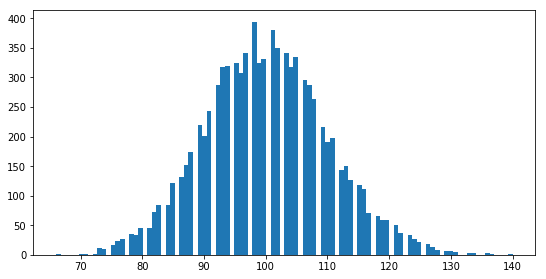

In [5]:
# Lets construct a background signal
signal_probability = 0.1
data_points = 10000

# calculated constants
sig_points = int(data_points * signal_probability)
back_points = data_points - sig_points

back_signal = poisson.rvs(mean, size=back_points)

figure = plt.figure(figsize=(9, 4.5))
ax = figure.subplots()
ax.hist(back_signal, bins=100);

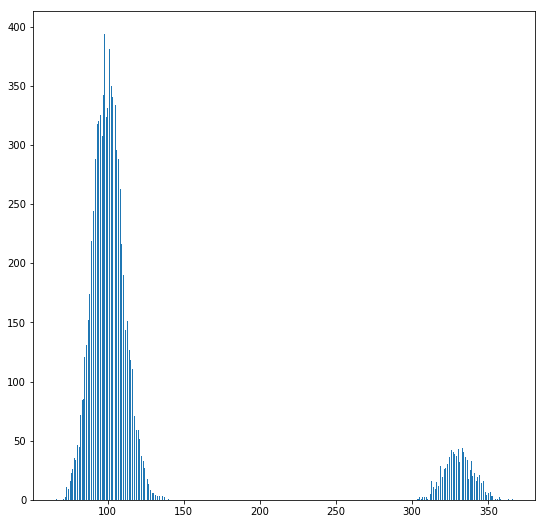

In [6]:
# Injected signal
inject_value = 230

inject_signal = np.add(np.ones(sig_points) * inject_value, 
                       poisson.rvs(mean, size=sig_points))
obs_signal = np.append(back_signal, inject_signal)

figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()
ax.hist(obs_signal, bins=500);

Our observed signal is going to appear very dim because of the number of background points we get. The histogram tells me it is most likely to get a background value.

### 2b.
Is your observed signal biased? (e.g. is the observed value equally likely to be stronger or weaker than the true injected signal?) Is it symmetric?

The observed signal is biased. It is far more likely to measure lower than a true injected signal, because most measurements are going to be that of the background. It is decidedly asymmetric.

## Problem 3
Now make a suite of injected signals. You will want to have a range of injected signal strengths, starting at zero and extending well above 5 sigma (30 sigma or more).

### 3a.
Clearly state what you are simulating, and make a 2D histogram of injected signal vs. observed signal.

(10000, 300)
(10000, 300)
(10000, 300)


ValueError: too many values to unpack (expected 2)

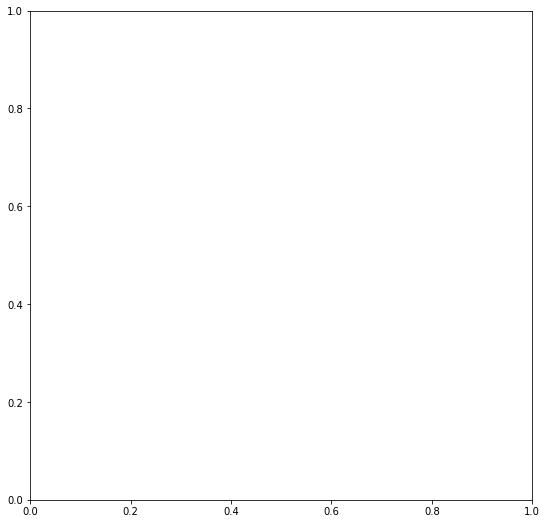

In [45]:
# I give up, I guess I'll show addition working.

signal_strength = np.arange(0, 300)
signal = np.repeat(np.meshgrid(signal_strength), 10000, axis=0)
noise = np.reshape(poisson.rvs(mean, size=10000), (10000, 1))
noise = np.repeat(noise, 300, axis=1)
print(signal.shape)
print(noise.shape)
observed = np.add(noise, signal)
print(observed.shape)

figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()

ax.hist2d(observed, signal, bins=100)

### 3b.
If you choose the same injected signal power as in problem 2, show that you get the same answer.

I mean, this is kinda redundant since I am just showing that adding a signal that affects all background will create a signal that is background plus the signal strength. So, I guess the answer is just the following.

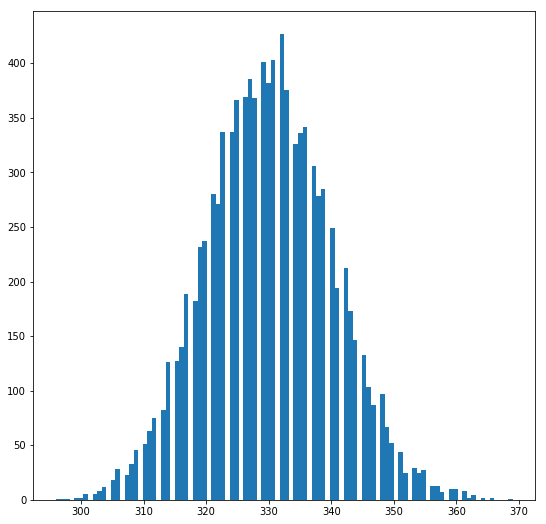

In [22]:
observed_signal = np.add(np.ones(10000) * inject_value, 
                        poisson.rvs(mean, size=10000))

figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()

ax.hist(observed_signal, bins=100);

This looks how I would expect, having all background points affected instead of just 10% like I showed in problem 2.

### 3c.
Now reverse the problem, select an observed signal (pick something quite a bit stronger than 5 sigma) and create a 1D histogram of the injected signal pdf(). Describe the meaning of this histogram.

### 3d.
For your observed signal, what is the 1 sigma uncertainty on the true signal strength?

### 3e.
Discuss the answer to part d in some depth. Is it symmetric? Is it biased? Does this make sense?

## Problem 4
Using the same setup as in problem 3, now pick a relatively weak signal (say in the 1 sigma range, exact strength not important).


### 4a.
Repeat problem **3c**, calculating the injected signal pdf(). One of the differences you should immediately see is that the pdf() extends to zero.

### 4b.
Describe what it means to have the true signal pdf() extend to zero.

### 4c.
Calculate a 95% confidence upper bound. [Hints: make sure your pdf() is normalized. The statistical question is: if I observe this candidate signal (and it is too weak to claim a detection), then the true signal would be less than *X* 95% of the time.]